<a href="https://colab.research.google.com/github/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/blob/main/Semana%201/Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importações padrões
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importando ferramentas
from sklearn.model_selection import KFold, RandomizedSearchCV

# Importações de classe Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet152
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Importando outras bibliotecas necessárias
import tensorflow as tf
from tensorflow.image import resize
import cv2
import zipfile
import os
import requests
import random

from sklearn.model_selection import train_test_split

In [ ]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Fazendo o download e organizado as imagens

## Listando endereços, fazendo downloads e organizando as imagens

In [ ]:
# Baixando imagem
!wget --no-check-certificate \
 https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
 -O /tmp/cats_and_dogs_filtered.zip

# Abrindo e extraindo o zip
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Definindo os diretórios
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Endereço dos diretórios finais
train_cats_dir = os.path.join(train_dir, 'cats') # Diretório com imagens de treinamentos de gatos
train_dogs_dir = os.path.join(train_dir, 'dogs') # Diretório com imagens de treinamentos de cacho
validation_cats_dir = os.path.join(validation_dir, 'cats') # Diretório com imagens de teste de gatos
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Diretório com imagens de teste de cach


# Lista com os endereços e local onde será armazenado as imagens
dirs =[train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir ]


# Listas para armazenar as imagens
images = [[] for _ in range(len(dirs))]


for i, dir in enumerate(dirs): # Loop para buscar as imagens em cada diretório e armazená-las em sua lista correspondente
    for filename in os.listdir(dir): # Iterando sobre cada arquivo no diretório
        if filename.endswith('.jpg'): # Verificando se o arquivo tem extensão .jpg
            img = cv2.imread(os.path.join(dir, filename)) # Carregando a imagem utilizando a função cv2.imread() e armazenando na variável img
            images[i].append(img) # Adicionando a imagem na lista correspondente em images

# Armazenando as imagens em suas devidas listas
# Criando as listas onde serão armazenadas todas as imagens
train_cats_img = images[0]
train_dogs_img = images[1]
validation_cats_img = images[2]
validation_dogs_img = images[3]


--2023-03-24 22:18:05--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   169MB/s    in 0.4s    

2023-03-24 22:18:05 (169 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Na seção abaixo, vamos plotar uma pequena amostra das imagens de cada uma das 4 listas que temos

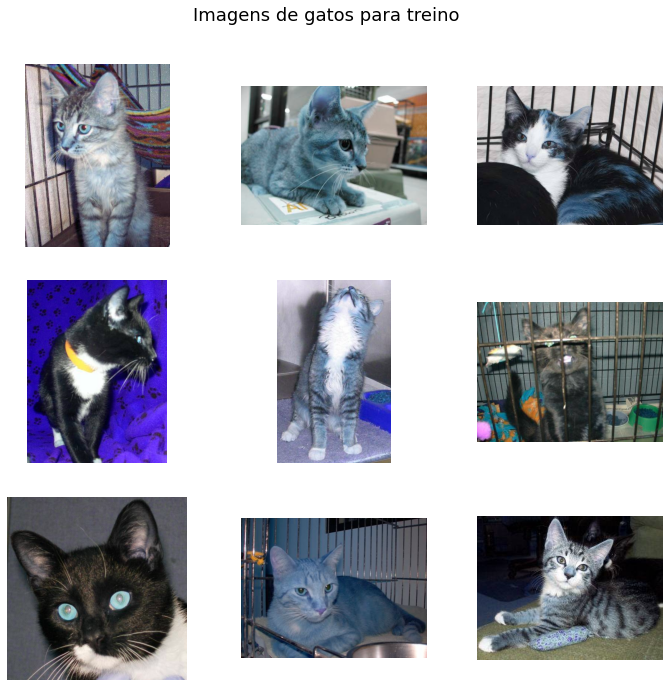

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout(pad=1.5, w_pad=2.0)
plt.subplots_adjust(top=0.9)

plt.suptitle("Imagens de gatos para treino", fontsize = 18)
for i in range(9):
    axs[(i // 3), (i % 3)].imshow(train_cats_img[i], cmap='gray')
    axs[(i // 3), (i % 3)].axis('off')
plt.show()

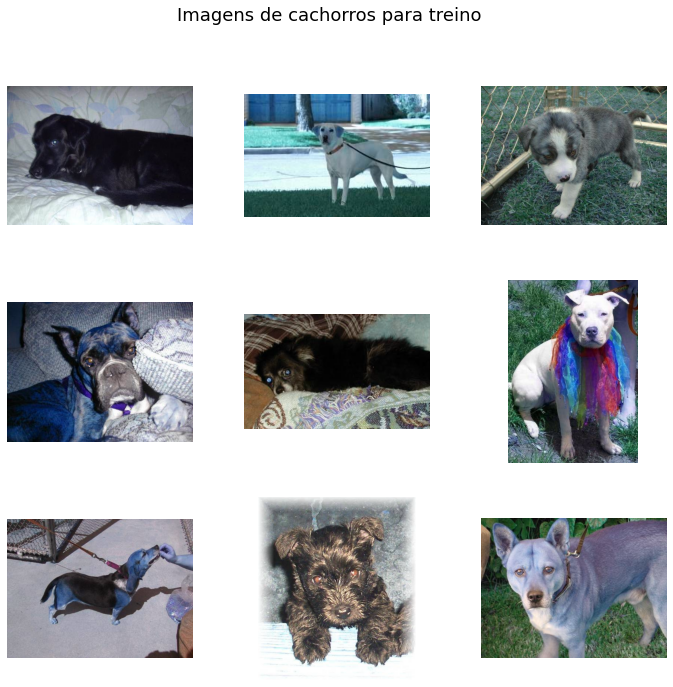

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout(pad=1.5, w_pad=2.0)
plt.subplots_adjust(top=0.9)

plt.suptitle("Imagens de cachorros para treino", fontsize = 18)
for i in range(9):
    axs[(i // 3), (i % 3)].imshow(train_dogs_img[i], cmap='gray')
    axs[(i // 3), (i % 3)].axis('off')
plt.show()

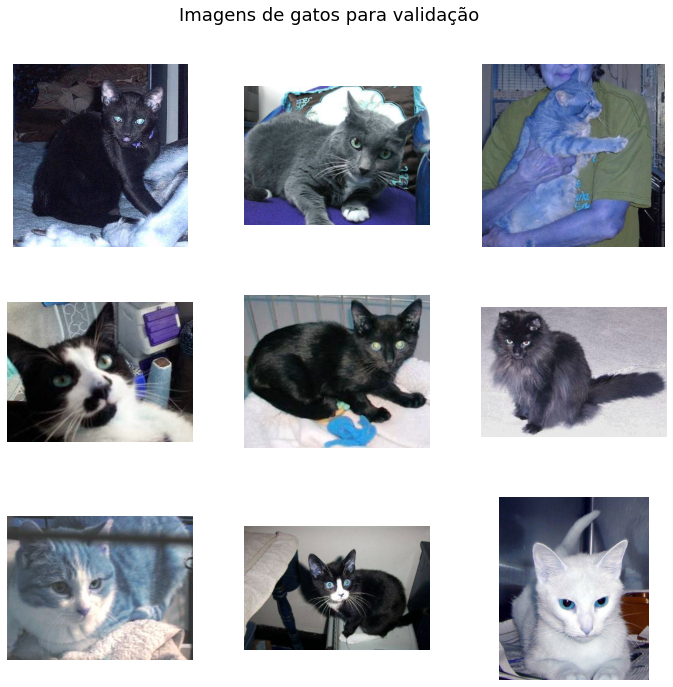

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout(pad=1.5, w_pad=2.0)
plt.subplots_adjust(top=0.9)

plt.suptitle("Imagens de gatos para validação", fontsize = 18)
for i in range(9):
    axs[(i // 3), (i % 3)].imshow(validation_cats_img[i], cmap='gray')
    axs[(i // 3), (i % 3)].axis('off')
plt.show()

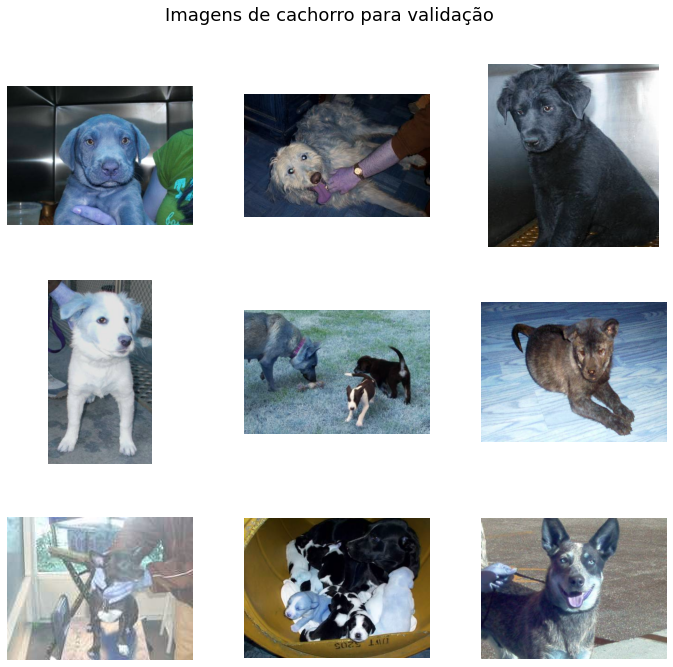

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout(pad=1.5, w_pad=2.0)
plt.subplots_adjust(top=0.9)


plt.suptitle("Imagens de cachorro para validação", fontsize = 18)
for i in range(9):
    axs[(i // 3), (i % 3)].imshow(validation_dogs_img[i], cmap='gray')
    axs[(i // 3), (i % 3)].axis('off')
plt.show()

## Juntando os dados em um único array e definindo X e y

In [ ]:

# Juntando as listas
gatos = train_cats_img + validation_cats_img
cachorros = train_dogs_img + validation_dogs_img

# Criando as listas de 'alvos'
gatos_y = np.repeat('0', len(gatos)) # Vamos estabelecer que gatos = 0
cachorros_y = np.repeat('1', len(cachorros)) # Vamos estabelecer que cachorros = 1
#cachorros_y = list(map(int, cachorros_y)) # Convertendo os valores de 'U1' para int

# Criando a nossas variáveis finals
X = np.concatenate((gatos, cachorros))
y = np.concatenate((gatos_y, cachorros_y))


# Uma vez que as listas estão sem embaralhar, tendo inicialmente só gatos e depois cachorros, vamos fazer um shuffle para evitar qualquer tipo de bias
# Usando a função zip para unir as duas listas e que todos os seus elementos sejam embaralhados de forma aleatóri simultaneamente
unidas = list(zip(X, y)) # Unir as duas listas
random.shuffle(unidas) # Embaralhar as duas listas
X, y = zip(*unidas) # Separar as listas embaralhadas


# Redimensionando para o tamanho solicitado
X = np.array([cv2.resize(img, (220, 128)) for img in X])


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Gerando 1000 imagens com data augmentation

Data augmentation é uma técnica utilizada para aumentar o tamanho do conjunto de dados de treinamento, gerando novas imagens a partir das imagens originais, através de transformações como rotações, translações, inversões, zooms, entre outras.

In [ ]:

X_aug = []
y_aug =  []

# Criar um gerador de imagens com as transformações desejadas
datagen = ImageDataGenerator(rotation_range=45, # Rotacionando em ângulos de 45%
                             width_shift_range=0.2, # Variando largura em 20%
                             height_shift_range=0.2) # Variando altura em 20%

# Quantidade de imagens geradas
n = 1000

# Gerar novas imagens a partir das originais e adicioná-las às listas existentes
for i in range(n):
    # Selecionar uma imagem aleatória
    idx = np.random.randint(len(X))
    img = X[idx]
    label = y[idx]
    
    # Aplicar as transformações na imagem selecionada
    img_aug = datagen.random_transform(img)
    
    # Adicionar a nova imagem e seu rótulo às listas existentes
    X_aug.append(img_aug)
    y_aug.append(label)
    
# Converter as listas em arrays numpy
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

# Adicionar as imagens geradas às imagens já existentes
X = np.concatenate((X, X_aug))
y = np.concatenate((y, y_aug))

# Separando os dados em treino e teste para aplicação dos modelos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Instanciando os modelos


In [ ]:
## VGG16
#vgg16 = VGG16(weights = None, include_top = False, input_shape = (128, 220, 3))

# Instanciando a rede VGG16
base_vgg16 = VGG16(weights = None, include_top = False, input_shape = (128, 220, 3))

# Instanciando a rede VGG19
base_vgg19 = VGG19(weights = None, include_top = False, input_shape = (128, 220, 3))

# Instanciando a rede ResNet152
base_resnet152 = ResNet152(weights = None, include_top = False, input_shape = (128, 220, 3))

In [ ]:
#VGG16
vgg16 = Sequential()
vgg16.add(base_vgg16)
vgg16.add(Flatten())
vgg16.add(Dense(256, activation = 'relu'))
vgg16.add(Dropout(0.5))
vgg16.add(Dense(1, activation = 'sigmoid'))

vgg16.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'] )

#VGG19
vgg19 = Sequential()
vgg19.add(base_vgg19)
vgg19.add(Flatten())
vgg19.add(Dense(256, activation = 'relu'))
vgg19.add(Dropout(0.5))
vgg19.add(Dense(1, activation = 'sigmoid'))

vgg19.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'] )

#ResNet152
resnet152 = Sequential()
resnet152.add(base_resnet152)
resnet152.add(Flatten())
resnet152.add(Dense(256, activation = 'relu'))
resnet152.add(Dropout(0.5))
resnet152.add(Dense(1, activation = 'sigmoid'))

resnet152.compile(loss = 'binary_crossentropy', optimizer = 'adam',metrics = ['accuracy'] )

In [ ]:
history_vgg16 = vgg16.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))
history_vgg19 = vgg19.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))
history_resnet152 = resnet152.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test))


  _, acc = history_vgg16.evaluate(X_test, y_test, verbose = 0)
  print('Acurácia final do modelo vgg16 = %.3f' % (acc * 100.0))
  
    _, acc = history_vgg19.evaluate(X_test, y_test, verbose = 0)
  print('Acurácia final do modelo vgg19 = %.3f' % (acc * 100.0))

    _, acc = history_resnet152.evaluate(X_test, y_test, verbose = 0)
  print('Acurácia final do modelo resnet152 = %.3f' % (acc * 100.0))



Epoch 1/30
